<a href="https://colab.research.google.com/github/Pmskabir1234/CNN-Project-01/blob/main/webui.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
#let's load the model
from tensorflow.keras.models import load_model
model = load_model("/content/drive/MyDrive/models/pneumonia_model.h5")

In [35]:

 # .kaggle folder
!mkdir -p ~/.kaggle

# Copy kaggle.json to that folder
!cp kaggle.json ~/.kaggle/

# Change permissions (important!)
!chmod 600 ~/.kaggle/kaggle.json

In [36]:
!kaggle datasets download -d paultimothymooney/chest-xray-pneumonia


Dataset URL: https://www.kaggle.com/datasets/paultimothymooney/chest-xray-pneumonia
License(s): other
chest-xray-pneumonia.zip: Skipping, found more recently modified local copy (use --force to force download)


In [37]:
import zipfile

with zipfile.ZipFile('chest-xray-pneumonia.zip', 'r') as zip_ref:
    zip_ref.extractall('chest_xray')

In [38]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_dir = 'chest_xray/chest_xray/test'

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_dir,
    target_size = (150,150),
    batch_size = 32,
    class_mode = 'binary',
    shuffle = False
)

preds = model.predict(test_gen)

Found 624 images belonging to 2 classes.


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


20/20 ━━━━━━━━━━━━━━━━━━━━ 12s 573ms/step


In [39]:
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

y_pred = (preds > 0.5).astype(int)
y_true = test_gen.classes


In [40]:
print(classification_report(y_true,y_pred, target_names = ['Normal','Pneumonia']))

              precision    recall  f1-score   support

      Normal       0.93      0.65      0.77       234
   Pneumonia       0.82      0.97      0.89       390

    accuracy                           0.85       624
   macro avg       0.88      0.81      0.83       624
weighted avg       0.86      0.85      0.84       624



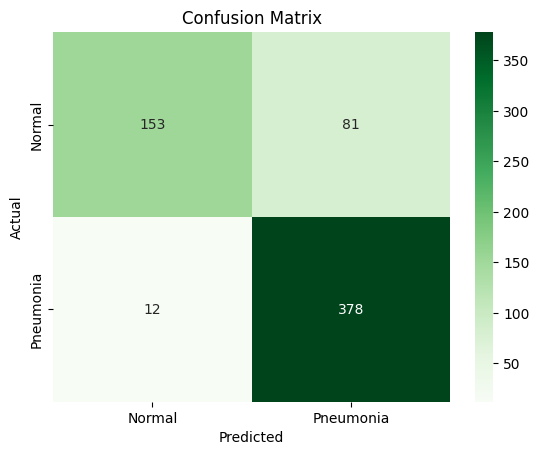

In [41]:
cm = confusion_matrix(y_true,y_pred)
sns.heatmap(cm, annot = True, fmt='d', cmap='Greens',
            xticklabels = ['Normal','Pneumonia'],
            yticklabels=['Normal','Pneumonia']
            )
plt.xlabel("Predicted")
plt.ylabel('Actual')
plt.title("Confusion Matrix")
plt.show()

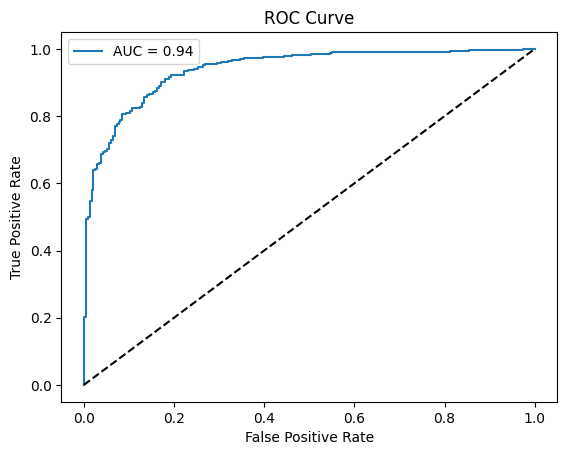

In [42]:
fpr, tpr, thresholds = roc_curve(y_true, preds)
roc_auc = auc(fpr,tpr)
plt.plot(fpr, tpr, label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()


In [43]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 148, 148, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 74, 74, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 72, 72, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 36, 36, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 82944)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    10,616,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 10,636,483 (40.57 MB)

 Trainable params: 10,636,481 (40.57 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [44]:
#now we'll setup a web ui for user to upload X-ray and the model will be predicting
import gradio as gr
from tensorflow.keras.preprocessing import image
import numpy as np
from PIL import Image

In [45]:
#setting up the function
def detect(img):

  #preprocessings
  img = img.resize((150,150))
  img_array = image.img_to_array(img)
  img_array = np.expand_dims(img_array,axis=0)/255.0

  #predicting
  pred =  model.predict(img_array)
  label = "🫁 Pneumonia Detected" if pred[0][0] > 0.5 else "✅ Normal Lungs"
  chance = round(float(pred[0][0])*100,2) if pred[0][0] > 0.5 else round((1-float(pred[0][0]))*100,2)
  return f"{label}      Chance : {chance}%"

#setting up the interface
demo = gr.Interface(
    fn = detect,
    inputs=gr.Image(type='pil',label='Upload the chest X-ray'),
    outputs = gr.Textbox(label='Prediction'),
    title='Pneumonia Detector',
    description="Upload a chest X-ray to get AI-powered diagnosis. Built by Saad Kabir",
)

#now launch
if __name__ == "__main__":
  demo.launch()

It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://03c322102e2eaaa517.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
